# Calibrating qubits using Qiskit Pulse

## Setup

In [7]:
from qiskit import *

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    )
myBackend = service.least_busy(operational=True, simulator=False)
myBackend.name

'ibm_brisbane'

In [9]:
backend_config = myBackend.configuration()
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.5 ns


In [10]:
myBackend.configuration().timing_constraints

{'acquire_alignment': 8,
 'granularity': 8,
 'min_length': 16,
 'pulse_alignment': 8}

In [11]:
acquire_alignment = myBackend.configuration().timing_constraints['acquire_alignment']
granularity = myBackend.configuration().timing_constraints['granularity']
pulse_alignment = myBackend.configuration().timing_constraints['pulse_alignment']

In [12]:
import numpy as np

least_common_multiple = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {least_common_multiple}")

Least common multiple of acquire_alignment and pulse_alignment: 8


In [13]:
backend_defaults = myBackend.defaults()


## Finding qubit frequency using Frequency Sweep

In [67]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit0 = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit0]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit0} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

# We will sweep 40 MHz around the estimated frequency
bandwidth = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
freq_min = center_frequency_Hz - bandwidth / 2
freq_max = center_frequency_Hz + bandwidth / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(freq_min / GHz, 
                            freq_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The frequency sweep goes from {freq_min / GHz} GHz to {freq_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.721908559753585 GHz.
The sweep will go from 4.701908559753585 GHz to 4.741908559753585 GHz in steps of 1.0 MHz.


In [15]:
def find_closest_multiple(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)

In [16]:
# samples need to be multiples of 16
def find_closest_multiple_16(num):
    return find_closest_multiple(num, granularity)

In [17]:
# Convert seconds to dt
def find_delta_t(sec):
    return find_closest_multiple(sec/dt, least_common_multiple)

In [18]:
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate

# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.015 * us                           # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8                # This is a truncating parameter, because gaussians don't have 
                                                        # a natural finite length
drive_amplitude = 0.05

# Create the base schedule
# Start with drive pulse acting on the drive channel
frequency = Parameter('freq')
with pulse.build(backend=myBackend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = find_closest_multiple_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit0)
    pulse.set_frequency(frequency, drive_chan)
    # Drive pulse samples
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amplitude,
                              name='freq_sweep_excitation_pulse'), drive_chan)

In [19]:
sweep_gate = Gate("sweep", 1, [frequency])

qcircuit_sweep = QuantumCircuit(1, 1)

qcircuit_sweep.append(sweep_gate, [0])
qcircuit_sweep.measure(0, 0)
qcircuit_sweep.add_calibration(sweep_gate, (0,), sweep_sched, [frequency])

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
exp_sweep_circs = [qcircuit_sweep.assign_parameters({frequency: f}, inplace=False) for f in frequencies_Hz]

In [64]:
# from qiskit import schedule

# sweep_schedule = schedule(exp_sweep_circs[0], myBackend)
# sweep_schedule.draw(backend=myBackend)

In [28]:
num_shots_per_frequency = 1024

job = myBackend.run(exp_sweep_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

In [29]:
# from qiskit.tools.monitor import job_monitor
# job_monitor(job)

In [30]:
freq_sweep_results = job.result() # timeout parameter set to 120 seconds

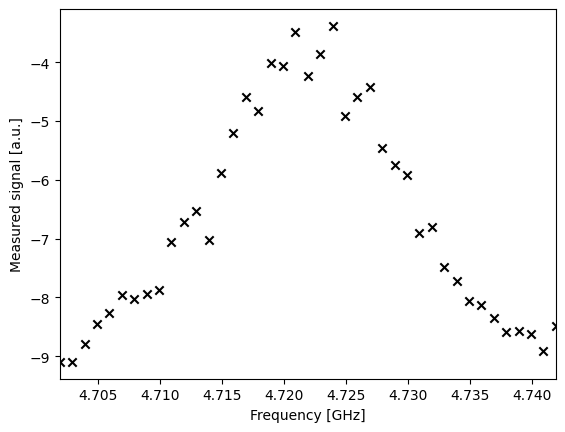

In [31]:
import matplotlib.pyplot as plt

sweep_vals = []
for i in range(len(freq_sweep_results.results)):
    # Get the results from the ith experiment
    res = freq_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_vals.append(res[qubit0])

plt.scatter(frequencies_GHz, np.real(sweep_vals), marker='x', color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [32]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev=5000)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

fit_parameters, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_vals), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [1, 4.975, 1, -2] # initial parameters for curve_fit
                                )

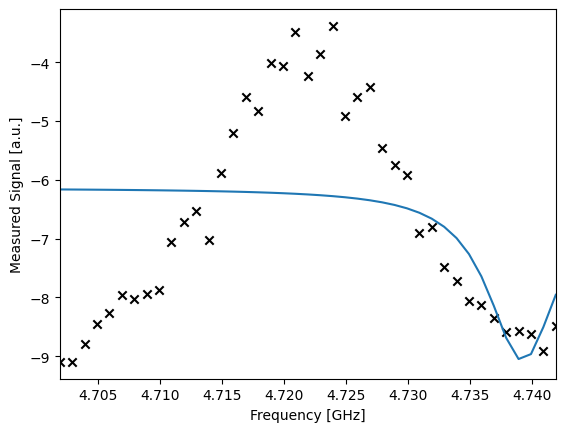

In [33]:
plt.scatter(frequencies_GHz, np.real(sweep_vals), marker='x', color='black')
plt.plot(frequencies_GHz, y_fit)
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [34]:
A, rough_qubit_frequency, B, C = fit_parameters
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit0] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.72191 GHz to 4.73923 GHz.


## Calibrating and using a pi Pulse

In [35]:
# This experiment uses these values from the previous experiment:
# `qubit`,and
# `rough_qubit_frequency`.

# Rabi experiment parameters
n_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, n_rabi_points)

In [38]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.

drive_amplitude = Parameter('drive_amp')
with pulse.build(backend=myBackend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = find_closest_multiple_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit0)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amplitude,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)

In [39]:
rabi_qgate = Gate("rabi", 1, [drive_amplitude])

qcircuit_rabi = QuantumCircuit(1, 1)

qcircuit_rabi.append(rabi_qgate, [0])
qcircuit_rabi.measure(0, 0)
qcircuit_rabi.add_calibration(rabi_qgate, (0,), rabi_sched, [drive_amplitude])

exp_rabi_circs = [qcircuit_rabi.assign_parameters({drive_amplitude: a}, inplace=False) for a in drive_amps]

In [40]:
# rabi_schedule = schedule(exp_rabi_circs[-1], backend)
# rabi_schedule.draw(backend=backend)

In [41]:
num_shots_per_point = 1024

job2 = myBackend.run(exp_rabi_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

# job_monitor(job2)

In [42]:
rabi_results = job2.result(timeout=120)

In [43]:
# center data around 0
def center_data_at_0(vals):
    return np.array(vals) - np.mean(vals)

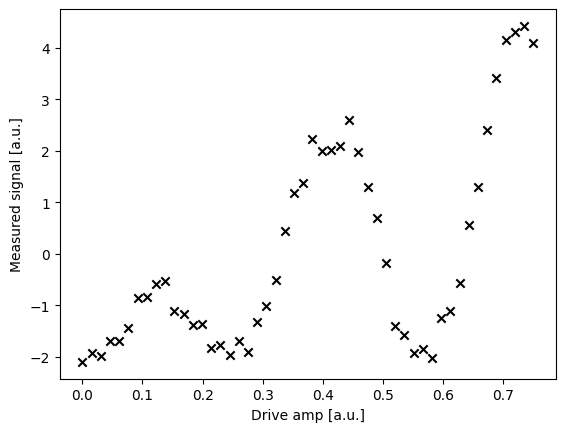

In [44]:
rabi_vals = []
for i in range(n_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_vals.append(rabi_results.get_memory(i)[qubit0] * scale_factor)

rabi_vals = np.real(center_data_at_0(rabi_vals))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_vals, marker='x', color='black') # plot real part of Rabi values
plt.show()

<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jessd\AppData\Local\Temp\ipykernel_7464\3405866220.py:14: SyntaxWarning: invalid escape sequence '\p'
  plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1))


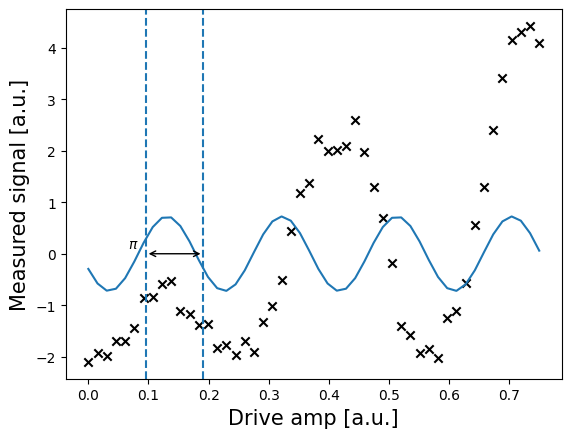

In [46]:
fit_parameters, y_fit = fit_function(drive_amps,
                                 rabi_vals, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [2, 0, 0.2, 0])

plt.scatter(drive_amps, rabi_vals, marker='x', color='black')
plt.plot(drive_amps, y_fit)

drive_period = fit_parameters[2] # get period of rabi oscillation

plt.axvline(drive_period/2, linestyle='--')
plt.axvline(drive_period, linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->"))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1))


plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [47]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.0956590219513228


Define pi pulse

In [49]:
with pulse.build(myBackend) as pi_pulse:
    drive_duration = find_closest_multiple_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit0)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

Determine 0 vs 1

In [50]:
# Ground state 
qcircuit_ground = QuantumCircuit(1, 1)
qcircuit_ground.measure(0, 0)

In [52]:
# Excited state
with pulse.build(backend=myBackend, default_alignment='sequential', name='excited state') as exc_schedule:
    drive_chan = pulse.drive_channel(qubit0)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse)

In [53]:
qcircuit_excited = QuantumCircuit(1, 1)
qcircuit_excited.x(0)
qcircuit_excited.measure(0, 0)

qcircuit_excited.add_calibration("x", (0,), exc_schedule, [])

In [55]:
# # Execution settings
num_shots = 1024

job3 = myBackend.run([qcircuit_ground, qcircuit_excited], 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

# job_monitor(job3)

In [56]:
ground_excited_results = job3.result()


C:\Users\jessd\AppData\Local\Temp\ipykernel_7464\3844712108.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(gnd_results), np.imag(gnd_results),
C:\Users\jessd\AppData\Local\Temp\ipykernel_7464\3844712108.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(exc_results), np.imag(exc_results),
C:\Users\jessd\AppData\Local\Temp\ipykernel_7464\3844712108.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(mean_gnd), np.imag(mean_gnd),
C:\Users\jessd\AppData\Local\Temp\ipykernel_7464\3844712108.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.real(mean_exc), np.imag(mean_exc),


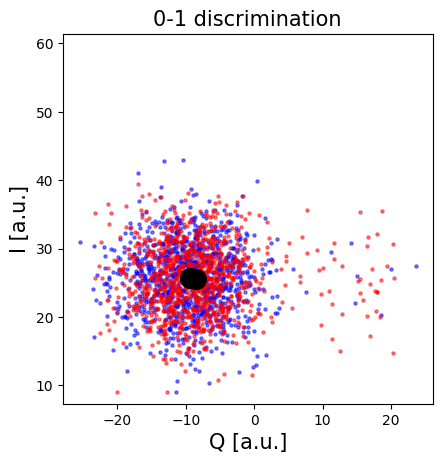

In [57]:
ground_results = ground_excited_results.get_memory(0)[:, qubit0]*scale_factor
excited_results = ground_excited_results.get_memory(1)[:, qubit0]*scale_factor

plt.figure()

# Plot all the results
# All results from the ground state are plotted in blue
plt.scatter(np.real(ground_results), np.imag(ground_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the excited state are plotted in red
plt.scatter(np.real(excited_results), np.imag(excited_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

plt.axis('square')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(ground_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(excited_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

In [58]:
import math

def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))

Measuring T1 using Inversion Recovery

In [78]:
import numpy as np

# Define microseconds abbreviation
us = 1e-6

# T1 experiment parameters
time_max = 450 * us
time_step = 6.5 * us
delay_times = np.arange(1 * us, time_max, time_step)

# We will use the same `pi_pulse` and qubit frequency that we calibrated and used before

In [79]:
delay = Parameter('delay')
qcircuit_t1 = QuantumCircuit(1, 1)

qcircuit_t1.x(0)
qcircuit_t1.delay(delay, 0)
qcircuit_t1.measure(0, 0)
qcircuit_t1.add_calibration("x", (0,), pi_pulse)

exp_t1_circuits = [qcircuit_t1.assign_parameters({delay: find_delta_t(d)}, inplace=False) for d in delay_times]

In [80]:
# Execution settings
num_shots = 256

job4 = myBackend.run(exp_t1_circuits, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

# job_monitor(job4)

In [88]:
t1_results = job4.result()


<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
C:\Users\jessd\AppData\Local\Temp\ipykernel_7464\721097464.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)


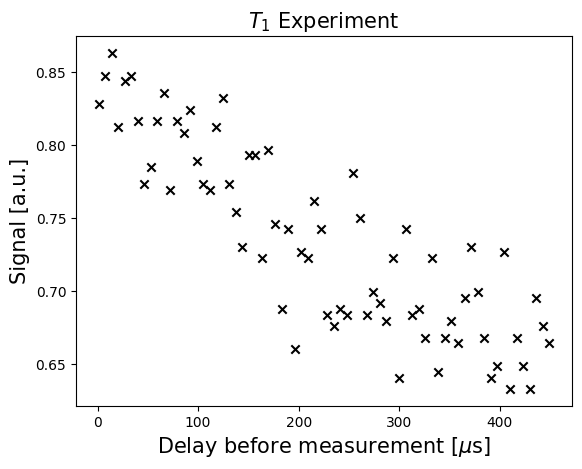

In [89]:
t1_vals = []

for i in range(len(delay_times)):
    iq_data = t1_results.get_memory(i)[:,qubit0] * scale_factor
    t1_vals.append(sum(map(classify, iq_data)) / num_shots)

plt.scatter(delay_times/us, t1_vals, marker='x', color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
C:\Users\jessd\AppData\Local\Temp\ipykernel_7464\1017210451.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)


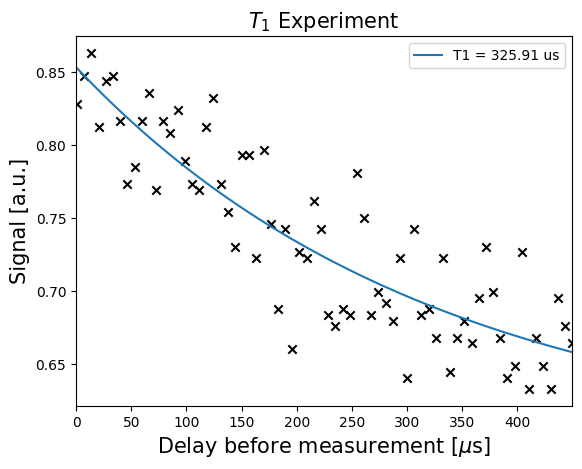

In [90]:
# Fit the data
fit_parameters, y_fit = fit_function(delay_times/us, t1_vals, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_parameters

plt.scatter(delay_times/us, t1_vals, marker='x', color='black')
plt.plot(delay_times/us, y_fit, label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(delay_times/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

## Determining qubit Coherence

Measuring the qubit Frequency Precisely using a Ramsey Experiment

In [92]:
# Ramsey experiment parameters
time_max = 1.8 * us
time_step = 0.025 * us
delay_times = np.arange(0.1 * us, time_max, time_step)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amplitude = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(myBackend) as x90_pulse:
    drive_duration = find_closest_multiple_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit0)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amplitude,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

In [93]:
detuning_MHz = 2 
ramsey_freq = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz
# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=myBackend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit0)
    pulse.set_frequency(ramsey_freq, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [94]:
ramsey_qgate = Gate("ramsey", 1, [delay])

qcircuit_ramsey = QuantumCircuit(1, 1)

qcircuit_ramsey.append(ramsey_qgate, [0])
qcircuit_ramsey.measure(0, 0)
qcircuit_ramsey.add_calibration(ramsey_qgate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qcircuit_ramsey.assign_parameters({delay: find_delta_t(d)}, inplace=False) for d in delay_times]

In [96]:
# Execution settings
num_shots = 256

job5 = myBackend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

# job_monitor(job)

In [127]:
ramsey_results = job5.result()

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
C:\Users\jessd\AppData\Local\Temp\ipykernel_7464\1548977420.py:10: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)


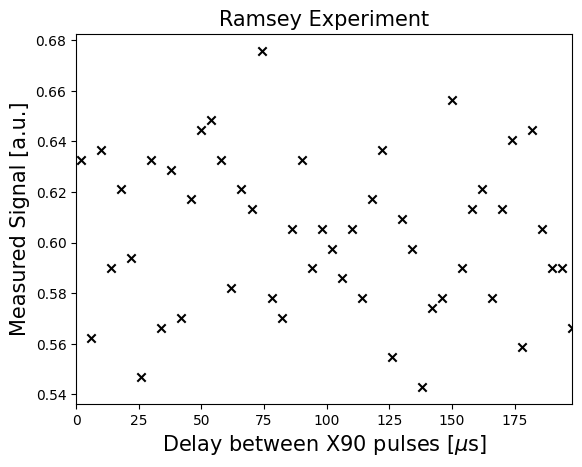

In [128]:
ramsey_vals = []

for i in range(len(delay_times)):
    iq_data = ramsey_results.get_memory(i)[:,qubit0] * scale_factor
    ramsey_vals.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times/us, np.real(ramsey_vals), marker='x', color='black')
plt.xlim(0, np.max(delay_times/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
C:\Users\jessd\AppData\Local\Temp\ipykernel_7464\3094698754.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)


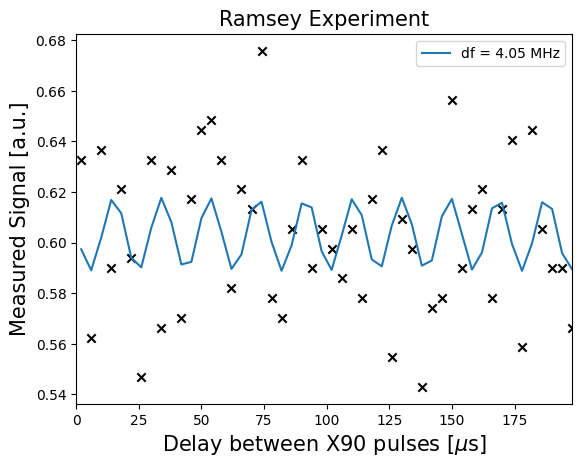

In [129]:
fit_parameters, y_fit = fit_function(delay_times/us, np.real(ramsey_vals),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [5, 4, 0, 0.25]  # you may need to adjust these
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_parameters # freq is MHz since times in us

plt.scatter(delay_times/us, np.real(ramsey_vals), marker='x', color='black')
plt.plot(delay_times/us, y_fit, label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(delay_times/us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

In [130]:
precise_qubit_freq = rough_qubit_frequency + (detuning_MHz - del_f_MHz) * MHz # get new freq in Hz
print(f"Our updated qubit frequency is now {round(precise_qubit_freq/GHz, 6)} GHz. "
      f"It used to be {round(rough_qubit_frequency / GHz, 6)} GHz")

Our updated qubit frequency is now 4.737183 GHz. It used to be 4.739235 GHz


Measuring T2 using Hahn Echoes

In [102]:
# T2 experiment parameters
tau_max = 200 * us
tau_step = 4 * us
delay_times = np.arange(2 * us, tau_max, tau_step)

# We will use the pi_pulse and x90_pulse from previous experiments

In [104]:
delay = Parameter('delay')
with pulse.build(backend=myBackend, default_alignment='sequential', name="T2 delay Experiment") as t2_schedule:
    drive_chan = pulse.drive_channel(qubit0)
    pulse.set_frequency(precise_qubit_freq, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(pi_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [105]:
t2_qgate = Gate("t2", 1, [delay])

qcircuit_t2 = QuantumCircuit(1, 1)

qcircuit_t2.append(t2_qgate, [0])
qcircuit_t2.measure(0, 0)
qcircuit_t2.add_calibration(t2_qgate, (0,), t2_schedule, [delay])

exp_t2_circs = [qcircuit_t2.assign_parameters({delay: find_delta_t(d)}, inplace=False) for d in delay_times]

In [111]:
# Execution settings
num_shots_per_point = 512

job6 = myBackend.run(exp_t2_circs,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots_per_point)

In [112]:
t2_results = job6.result(timeout=120)


<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jessd\AppData\Local\Temp\ipykernel_7464\2370066748.py:8: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)


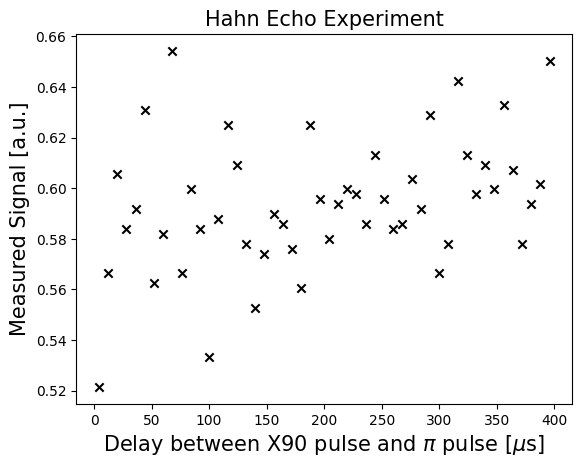

In [113]:
t2_vals = []

for i in range(len(delay_times)):
    iq_data = t2_results.get_memory(i)[:,qubit0] * scale_factor
    t2_vals.append(sum(map(classify, iq_data)) / num_shots_per_point)

plt.scatter(2*delay_times/us, t2_vals, marker='x', color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jessd\AppData\Local\Temp\ipykernel_7464\4031798140.py:11: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)


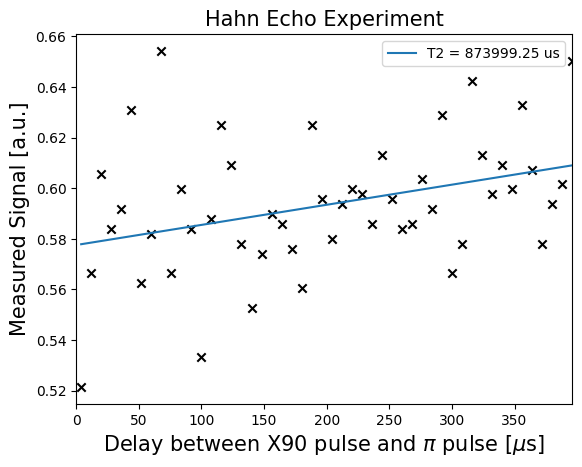

In [114]:
fit_parameters, y_fit = fit_function(2*delay_times/us, t2_vals,
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

_, _, T2 = fit_parameters
print()

plt.scatter(2*delay_times/us, t2_vals, marker='x', color='black')
plt.plot(2*delay_times/us, y_fit, label=f"T2 = {T2:.2f} us")
plt.xlim(0, np.max(2*delay_times/us))
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.show()